# Highspot Take Home Project - Scott Burger

# Executive Summary

In this document, we present high-level findings from three tables of data: 
* Engagements between sales representatives and customers (**rep_data**).
   * Many reps do not have any data which needs to be removed prior to modelling.
   * The channel_spend1 field has the best number of engagements per dollar spend.
   
   
* Customer-specific data like yearly revenue and customer size (**customer_data**).
    * Customer types are split between small, medium, and large Industry groups.
    * Industry1 outranks Industry3 then Industry2 for how much the target deal size grows as a function of the company's yearly revenue.


* Engagement data between sales representatives and customers (**engagement_data**).
    * There are more engagements without prior contact than with prior contact.
    * The average actual deal size is higher for a prior contact engagement by almost 100,000.
    * High touch engagements have a lower average actual deal size.

We then present two modelling scenarios:
* First, building a data set by joining **rep_data** to the **engagement_data** table.


* Linearly modelling actual deal size as a function of channel spend.
    * Here we determined a best-fit model as:
      * $\text{Actual Deal Size} = 29\cdot C_1 + 5.99\cdot C_2 +  16.89\cdot C_3 -16.51\cdot C_4 + 29.07\cdot C_5 + 1426837.78$


* Classification model to determine if the target minus actual deal size is positive.
    * False-positive rates with the classification model very high. The precision is 59% and recall is 68%.


* We conclude that the linear model result is better to use than the logistic classifier based on its false-positive rate.

# Table of Contents

* Exploratory Data Analysis

* Key Metric Choosing for Modelling

* Model Building and Evaluation


## Exploratory Data Analysis - rep_data

First let's do some data exploration on the tables that we already have, starting with the rep_data table. We have a number of interesting questions we can ask, but before we jump in to those, it's best to assess data quality: how many NAs are there for a given column of the data?

In [57]:
#load the datasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

customer_data = pd.read_csv("customer_data.csv")
engagement_data = pd.read_csv("engagement_data.csv")
rep_data = pd.read_csv("rep_data.csv")

In [7]:
rep_data.tail()

,customer_id,rep_id,channel_spend1,channel_spend2,channel_spend3,channel_spend4,channel_spend5,num_engagements
6430,Customer45,Rep139,4556.61,20.64,10.00,1601.01,3288.25,12
6431,Customer45,Rep140,5046.74,NaN,18.82,2253.43,2340.01,12
6432,Customer45,Rep141,1956.28,NaN,10.00,599.32,3990.54,12
6433,Customer45,Rep142,2004.02,NaN,10.00,437.73,1537.49,12
6434,Customer45,Rep143,4018.91,58.08,100.00,211.94,858.33,12


As we can see from a preview of the data, there are some NAs present, so we should be dilligent to quantify them:

In [8]:
rep_data.count() / len(rep_data)

customer_id        1.000000
rep_id             1.000000
channel_spend1     0.354312
channel_spend2     0.254390
channel_spend3     0.317949
channel_spend4     0.305361
channel_spend5     0.356643
num_engagements    1.000000
dtype: float64

This amout of data loss implies the question: is the data that lossy for all reps and all customers or just some? So let's look at the total count of NA values per customer and total count of NA values per rep:

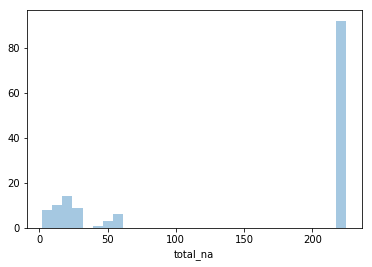

In [9]:
null_rep = rep_data.groupby('rep_id').agg(lambda x: x.isnull().sum())
null_rep['total_na'] = null_rep.sum(axis=1)
null_rep.sort_values(['total_na'], ascending=False)
sns.distplot(null_rep['total_na'], kde=False, bins=30)

According to the above histogram, we have more than 200 reps that have basically no channel spend data. The rest may have a few channels missing, but not all of them and not to a large fraction of their total. This begs the question of how the customer data looks for the same channel spend metrics:

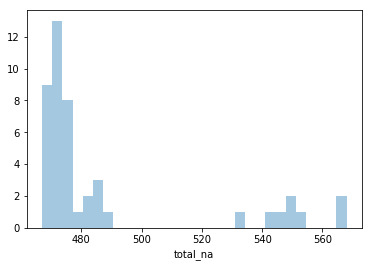

In [10]:
null_cust = rep_data.groupby('customer_id').agg(lambda x: x.isnull().sum())
null_cust['total_na'] = null_cust.sum(axis=1)
null_cust.sort_values(['total_na'], ascending=False)
sns.distplot(null_cust['total_na'], kde=False, bins=30)

The customer data here is a lot less extreme in its count of NAs. There are a large number of customer ids that have a couple NA values and, at worst, some that have as many as 12. This leads us to the conclusion that we could drop the rep ids that have null values for all of their channel spend data and then see what the value counts are. If the total NAs are substantially lower, then we can impute the few remaining NA values to make our dataset more robust.

In [11]:
null_rep_ids = null_rep[null_rep['total_na'] >= 200].reset_index()['rep_id']  #list of rep_ids that have all null channel spend
rep_data_filtered = rep_data[~rep_data['rep_id'].isin(null_rep_ids)] #removing rep_ids from original list from out filter list
rep_data_filtered.count() / len(rep_data_filtered)

customer_id        1.000000
rep_id             1.000000
channel_spend1     0.993464
channel_spend2     0.713290
channel_spend3     0.891503
channel_spend4     0.856209
channel_spend5     1.000000
num_engagements    1.000000
dtype: float64

These value counts look much better in terms of percentages being NAs. Before we were looking at all the channel spends being 75% null and now closer to 10% on average. We can go ahead and impute the missing data for the rest by putting in the average values for the given channel spend column.


In [12]:
rep_data_imputed = rep_data_filtered
rep_data_imputed = rep_data_imputed.fillna(rep_data_imputed.mean())
rep_data_imputed.count() / len(rep_data_imputed)

customer_id        1.0
rep_id             1.0
channel_spend1     1.0
channel_spend2     1.0
channel_spend3     1.0
channel_spend4     1.0
channel_spend5     1.0
num_engagements    1.0
dtype: float64

Great! Now we have all of our data without any missing records. Let's add one more column, which is a sum of all the other channel spend data:

In [13]:
rep_data_imputed['total_spend'] = \
rep_data_imputed['channel_spend1'] + \
rep_data_imputed['channel_spend2'] + \
rep_data_imputed['channel_spend3'] + \
rep_data_imputed['channel_spend4'] + \
rep_data_imputed['channel_spend5'] 

Now let's see how the channel spend per number of engagements looks:

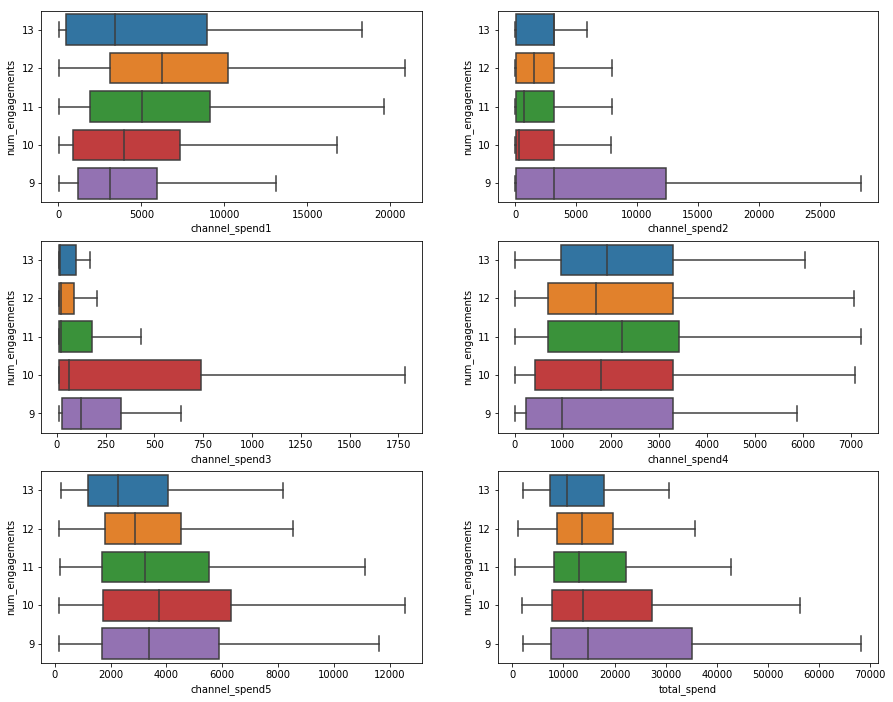

In [14]:
fig, axes = plt.subplots(3,2)

fig.set_size_inches(15,12)

ax = sns.boxplot(y='num_engagements', x='channel_spend1', showfliers=False, orient='h', order=[13,12,11,10,9], data=rep_data_imputed, ax=axes[0,0])
ax = sns.boxplot(y='num_engagements', x='channel_spend2', showfliers=False, orient='h', order=[13,12,11,10,9], data=rep_data_imputed, ax=axes[0,1])
ax = sns.boxplot(y='num_engagements', x='channel_spend3', showfliers=False, orient='h', order=[13,12,11,10,9], data=rep_data_imputed, ax=axes[1,0])
ax = sns.boxplot(y='num_engagements', x='channel_spend4', showfliers=False, orient='h', order=[13,12,11,10,9], data=rep_data_imputed, ax=axes[1,1])
ax = sns.boxplot(y='num_engagements', x='channel_spend5', showfliers=False, orient='h', order=[13,12,11,10,9], data=rep_data_imputed, ax=axes[2,0])
ax = sns.boxplot(y='num_engagements', x='total_spend', showfliers=False, orient='h', order=[13,12,11,10,9], data=rep_data_imputed, ax=axes[2,1])


In this view, we see number of engagements as a function of channel spend with the total spend as the final box in the bottom right. The channel with the highest average number of engagements per total spend would be channel 1.

## Exploratory Data Analysis - customer_data

In this section, can get some quick insights from the data by looking at the average values cut by each industry 

* Industry3 has a much lower customer size than the other two and has a lower overall target deal size. The yearly revenue for these, likely smaller, customers is also lower. However, these customers have the highest year-over-year growth rate.
* Industry2 is larger in all metrics except for year-over-year growth.
* Industry1 is the largest across all fields, but lowest in year-over-year-growth. 
* By total counts, there are the most of Industry1 at 22, Industry2 at 17, and fewest of Idustry3 at 6
* If we were to classify these groups, it's likely that Industry1 is enterprise-level, Industry2 is small-medium business, and Industry3 are the smallest, likely startup level businesses.

In [53]:
customer_data.groupby('industry_id').describe().transpose()

industry_id                Industry1     Industry2     Industry3
customer_size    count  2.200000e+01  1.700000e+01  6.000000e+00
                 mean   1.772477e+05  1.011907e+05  4.054167e+04
                 std    4.939262e+04  3.237114e+04  1.304145e+03
                 min    3.969000e+04  3.487500e+04  3.969000e+04
                 25%    1.558408e+05  9.318800e+04  3.974500e+04
                 50%    2.024060e+05  1.145330e+05  3.991000e+04
                 75%    2.038190e+05  1.237370e+05  4.077400e+04
                 max    2.196220e+05  1.401670e+05  4.298800e+04
target_deal_size count  2.200000e+01  1.700000e+01  6.000000e+00
                 mean   1.762827e+06  1.661100e+06  1.418717e+06
                 std    7.069391e+05  5.977368e+05  4.463200e+05
                 min    7.706000e+05  8.175000e+05  9.088000e+05
                 25%    1.266850e+06  1.164500e+06  1.121200e+06
                 50%    1.529200e+06  1.491600e+06  1.361950e+06
                 75%    2.333325e+06  2.028400e+06  1.606900e+06
                 max    2.964600e+06  2.820000e+06  2.150100e+06
yearly_revenue   count  2.200000e+01  1.700000e+01  6.000000e+00
                 mean   4.231132e+07  4.123618e+07  3.269017e+07
                 std    1.463138e+07  1.645374e+07  1.110369e+07
                 min    2.003600e+07  1.880200e+07  2.272000e+07
                 25%    2.742150e+07  2.608500e+07  2.466675e+07
                 50%    4.275650e+07  3.821400e+07  2.923050e+07
                 75%    5.544000e+07  5.117000e+07  3.746700e+07
                 max    6.522100e+07  7.614000e+07  5.160200e+07
growth_yoy       count  2.200000e+01  1.700000e+01  6.000000e+00
                 mean   2.981909e+01  3.133000e+01  3.461167e+01
                 std    7.251657e+00  9.889068e+00  9.951280e+00
                 min    2.128000e+01  2.097000e+01  2.540000e+01
                 25%    2.571500e+01  2.422000e+01  2.634250e+01
                 50%    2.696000e+01  2.734000e+01  3.173500e+01
                 75%    3.410250e+01  4.224000e+01  4.354750e+01
                 max    4.909000e+01  4.888000e+01  4.677000e+01

We can see a lot of the same conclusions borne out in a colorized pair plot of the same data:

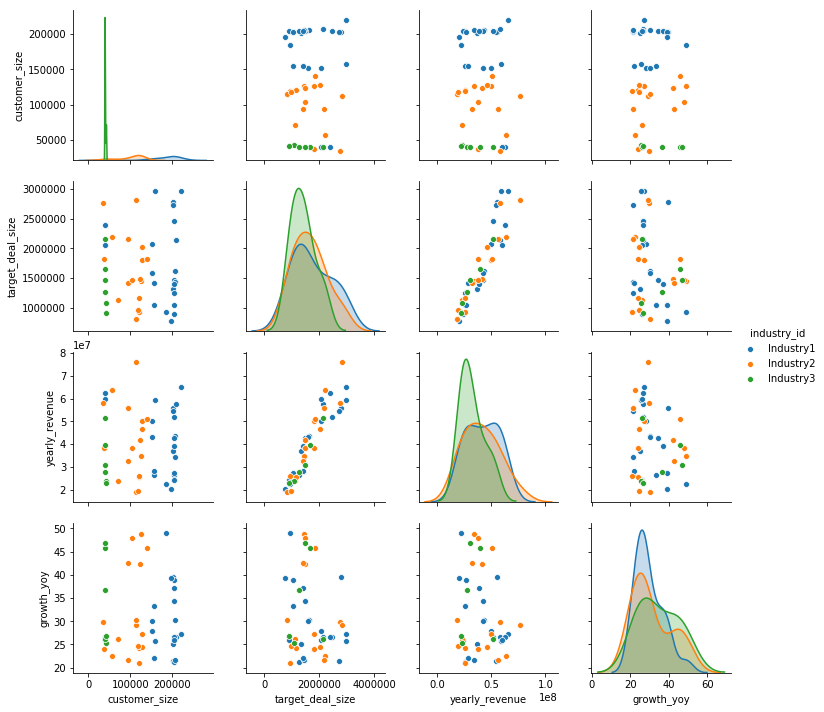

In [49]:
sns.pairplot(customer_data, hue='industry_id')

The only real interesting trend here appears to be target deal size as a function of yearly revenue. We can do some light regression modelling on this data to see what interesting results pop out as well:

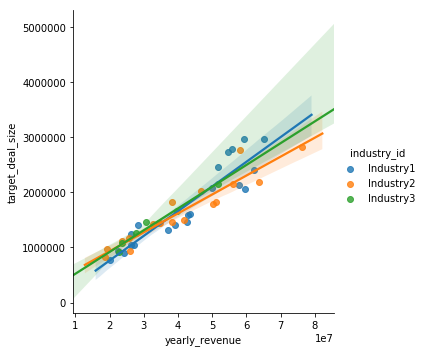

In [11]:
sns.lmplot(x='yearly_revenue', y='target_deal_size', hue='industry_id', data=customer_data)

From the above figure, we can see that Industry1 outranks Industry3 then Industry2 for how much the target deal size grows as a function of the company's yearly revenue. The confidence interval bands for Industry1 and Industry2 are about the same, but the bands for Industry3 are much wider as a result of larger spread in the data for that category.

## Exploratory Data Analysis - engagement_data

Finally some brief exploration into the **engagement_data** table. Some insights from the pivot table below:
* There are more engagements without prior contact than with prior contact.
* The average actual deal size is higher for a prior contact engagement by almost 100,000.
* High touch engagements have a lower average actual deal size.

In [65]:
engagement_data.groupby(['prior_contact', 'initial_channel_type']).describe().transpose()

prior_contact                  False                       True               
initial_channel_type       HighTouch      LowTouch     HighTouch      LowTouch
actual_deal_size count  2.151240e+05  1.767850e+05  1.624900e+04  1.341200e+04
                 mean   1.719295e+06  1.725713e+06  1.817656e+06  1.855801e+06
                 std    2.143864e+06  2.160656e+06  2.567655e+06  2.747349e+06
                 min    5.000000e+05  5.000000e+05  5.000000e+05  5.000000e+05
                 25%    5.000000e+05  5.000000e+05  5.000000e+05  5.000000e+05
                 50%    7.573000e+05  7.614000e+05  7.798000e+05  8.110500e+05
                 75%    2.012125e+06  2.014500e+06  2.125000e+06  2.112575e+06
                 max    4.042450e+07  4.069890e+07  6.930990e+07  6.497700e+07

## Key Metric Choosing for Modelling

When picking a feature variable to model against, for business purposes it's most impactful to choose something that either impacts revenue or revenue-driving metrics (ie daily active users). In this case, we have an **actual deal size** for a given **customer id**. If we wanted to model that deal size, we can do it in two ways: 
* modelling the deal size by channel spend metrics, which likely drive the interaction behavior to the final deal
* modelling the difference between target deal size and actual deal size as a function of channel spend

This modelling will effectivelly tell us how much money goes in yields how much comes out across all customer ids.

## Model Building and Evaluation: Linear Regression

linear regression on spend to get equation?

logistic to determine if positive or negative final deal size?


In [114]:
customer_deals_joined = pd.merge(engagement_data, customer_data, on='customer_id', how='left')
customer_deals_joined = pd.merge(customer_deals_joined, rep_data_imputed, on=['customer_id', 'rep_id'], how='left')

customer_deals_joined = customer_deals_joined[[
    'customer_id', \
    'engagement_type_id', \
    'rep_id', \
    'actual_deal_size', \
    'prior_contact', \
    'initial_channel_type', \
    'target_deal_size', \
    'channel_spend1', \

    'channel_spend2', \
    'channel_spend3', \
    'channel_spend4', \
    'channel_spend5', \
    'num_engagements'
]]

customer_deals_joined = customer_deals_joined.dropna()
customer_deals_joined['final_deal_size'] = customer_deals_joined['target_deal_size'] - customer_deals_joined['actual_deal_size']

customer_deals_joined.head()


,customer_id,engagement_type_id,rep_id,actual_deal_size,prior_contact,initial_channel_type,target_deal_size,channel_spend1,channel_spend2,channel_spend3,channel_spend4,channel_spend5,num_engagements,final_deal_size
92,Customer1,Medium1,Rep93,1869000,False,LowTouch,2081200,10382.90,6115.67,215.07,2406.62,6551.42,10.0,212200
93,Customer1,Medium1,Rep94,1905100,False,LowTouch,2081200,6074.12,254.39,51.98,427.39,5988.57,10.0,176100
94,Customer1,Medium1,Rep95,2091100,True,HighTouch,2081200,410.31,98.00,55805.51,10.00,554.92,10.0,-9900
95,Customer1,Medium1,Rep96,2529300,False,HighTouch,2081200,5629.51,68.00,1398.11,2084.64,20475.32,10.0,-448100
96,Customer1,Medium1,Rep97,3330600,False,HighTouch,2081200,4640.65,19.00,105.02,3639.42,14461.82,9.0,-1249400


In [115]:
from sklearn.model_selection import train_test_split

X = customer_deals_joined[['channel_spend1', 'channel_spend2', 'channel_spend3', 'channel_spend4', 'channel_spend5']]
y = customer_deals_joined['actual_deal_size']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

print(lm.intercept_)
print('\n')
print(pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient']))

1426837.78134242


                Coefficient
channel_spend1    29.006799
channel_spend2     5.991424
channel_spend3    16.897817
channel_spend4   -16.513966
channel_spend5    29.071727


From this model, we would have a function like:

$\text{Actual Deal Size} = 29\cdot C_1 + 5.99\cdot C_2 +  16.89\cdot C_3 -16.51\cdot C_4 + 29.07\cdot C_5 + 1426837.78$

## Logistic Regression Modelling

We can also run a logistic model to determine if the final deal size will be more or less than the target deal size:

In [117]:
customer_deals_joined.head()

,customer_id,engagement_type_id,rep_id,actual_deal_size,prior_contact,initial_channel_type,target_deal_size,channel_spend1,channel_spend2,channel_spend3,channel_spend4,channel_spend5,num_engagements,final_deal_size
92,Customer1,Medium1,Rep93,1869000,False,LowTouch,2081200,10382.90,6115.67,215.07,2406.62,6551.42,10.0,212200
93,Customer1,Medium1,Rep94,1905100,False,LowTouch,2081200,6074.12,254.39,51.98,427.39,5988.57,10.0,176100
94,Customer1,Medium1,Rep95,2091100,True,HighTouch,2081200,410.31,98.00,55805.51,10.00,554.92,10.0,-9900
95,Customer1,Medium1,Rep96,2529300,False,HighTouch,2081200,5629.51,68.00,1398.11,2084.64,20475.32,10.0,-448100
96,Customer1,Medium1,Rep97,3330600,False,HighTouch,2081200,4640.65,19.00,105.02,3639.42,14461.82,9.0,-1249400


In [118]:

def outcome(x):
    if x >= 0:
        return 1
    else:
        return 0

customer_deals_joined['final_deal_outcome'] = customer_deals_joined['final_deal_size'].apply(outcome)



prior_contact_d = pd.get_dummies(customer_deals_joined['prior_contact'], drop_first=True)
initial_channel_type_d = pd.get_dummies(customer_deals_joined['initial_channel_type'], drop_first=True)
customer_deals_joined.drop(['prior_contact', 'initial_channel_type'], axis=1, inplace=True)
customer_deals_joined = pd.concat([customer_deals_joined, prior_contact_d, initial_channel_type_d], axis=1)

customer_deals_joined.head()

,customer_id,engagement_type_id,rep_id,actual_deal_size,target_deal_size,channel_spend1,channel_spend2,channel_spend3,channel_spend4,channel_spend5,num_engagements,final_deal_size,final_deal_outcome,True,LowTouch
92,Customer1,Medium1,Rep93,1869000,2081200,10382.90,6115.67,215.07,2406.62,6551.42,10.0,212200,1,0,1
93,Customer1,Medium1,Rep94,1905100,2081200,6074.12,254.39,51.98,427.39,5988.57,10.0,176100,1,0,1
94,Customer1,Medium1,Rep95,2091100,2081200,410.31,98.00,55805.51,10.00,554.92,10.0,-9900,0,1,0
95,Customer1,Medium1,Rep96,2529300,2081200,5629.51,68.00,1398.11,2084.64,20475.32,10.0,-448100,0,0,0
96,Customer1,Medium1,Rep97,3330600,2081200,4640.65,19.00,105.02,3639.42,14461.82,9.0,-1249400,0,0,0


In [123]:
from sklearn.model_selection import train_test_split

X = customer_deals_joined[['channel_spend1', 'channel_spend2', 'channel_spend3', 'channel_spend4', 'channel_spend5', \
                           'num_engagements', 'LowTouch'
                          ]]
y = customer_deals_joined['final_deal_outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

print('Confusion matrix output:')
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, predictions))

print('\n')

print('Logistic evaluation metrics:')
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

C:\Users\scott\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion matrix output:
[[  237 14180]
 [  391 30622]]


Logistic evaluation metrics:
              precision    recall  f1-score   support

           0       0.38      0.02      0.03     14417
           1       0.68      0.99      0.81     31013

   micro avg       0.68      0.68      0.68     45430
   macro avg       0.53      0.50      0.42     45430
weighted avg       0.59      0.68      0.56     45430



From this output, we see that the that the model has a very high false positive rate, with 14,180 values being incorrectly classified. The model does seem to work well for predicting positive classes, however.